In [89]:
import numpy as np
import sqlite3

from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm

from utils.get_or_create_combined_database import get_or_create_combined_database
from utils.create_sequences_in_batches import calculate_sequences_in_batches
from utils.compare_models import compare_models
from utils.get_data import clear_cache, fetch_data_batches
from utils.recreate_cleaned_data import recreate_cleaned_data

from utils.create_sequences_in_batches import create_sequences_from_database_rows
from utils.plot_prediction_on_plot import plot_prediction_on_plot
from matplotlib import pyplot as plt

from constants import DB_columns

import os
from dotenv import load_dotenv
load_dotenv(verbose=True, override=True)

RECREATE_CLEANED_DATA = False

zoom_range = ((75, 14350), (75, 14350))
normalized_zoom_range = ((0, 1), (0, 1))

# Data

In [90]:
database_folder = os.getenv("DATABASE_FOLDER")

database_file = get_or_create_combined_database(database_folder)

table_name = "champs_cleaned"

Found 2 database files in the folder specified by DATABASE_FOLDER
Found combined database /u/23/tarpill1/unix/Documents/combined2.db


In [91]:
if RECREATE_CLEANED_DATA:
    recreate_cleaned_data(database_file, table_name)

In [92]:
# Check values from the new table

conn = sqlite3.connect(database_file)
cursor = conn.cursor()

page_size = 5

rows = cursor.execute(
    f"SELECT * FROM {table_name} LIMIT {page_size}").fetchall()

conn.close()

rows

[('Mordekaiser',
  604.0,
  612.0,
  5.5419455,
  645.0,
  100,
  2841236401,
  '2841236401_100_Mordekaiser',
  0.040266666666666666,
  0.0408,
  0.03078858611111111),
 ('Viego',
  786.0,
  436.0,
  5.5419455,
  630.0,
  100,
  2841236401,
  '2841236401_100_Viego',
  0.0524,
  0.029066666666666668,
  0.03078858611111111),
 ('Riven',
  364.0,
  136.0,
  5.5419455,
  745.0,
  100,
  2841236401,
  '2841236401_100_Riven',
  0.024266666666666666,
  0.009066666666666667,
  0.03078858611111111),
 ('Ezreal',
  132.0,
  402.0,
  5.5419455,
  600.0,
  100,
  2841236401,
  '2841236401_100_Ezreal',
  0.0088,
  0.0268,
  0.03078858611111111),
 ('Leblanc',
  298.0,
  676.0,
  5.5419455,
  598.0,
  100,
  2841236401,
  '2841236401_100_Leblanc',
  0.019866666666666668,
  0.045066666666666665,
  0.03078858611111111)]

# Models

In [93]:
import torch
import torch.nn as nn
import torch.optim as optim


def train_model(model, X_train, y_train, epochs=50, batch_size=64, learning_rate=0.001, cutoff_loss=None):
    device = model.device
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

    dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(epochs):
        pbar = tqdm(
            train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        for X_batch, y_batch in pbar:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            pbar.set_postfix({'Loss': loss.item()})
        current_loss = loss.item()
        if cutoff_loss is not None and current_loss < cutoff_loss:
            print(
                f'Loss is below cutoff value of {cutoff_loss}. Stopping training.')
            break
        pbar.close()


# Function to predict with the PyTorch model


def predict_model(model, X, batch_size=64):
    device = model.device
    model.to(device)
    model.eval()
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    dataset = torch.utils.data.TensorDataset(X_tensor)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    predictions = []
    pbar = tqdm(loader, desc='Predicting')
    with torch.no_grad():
        for X_batch, in pbar:
            output = model(X_batch)
            predictions.append(output.cpu().numpy())
    return np.vstack(predictions)


class TrajectoryPredictor(nn.Module):
    def __init__(self, input_shape, lstm_units=128, dropout_rate=0.2, device='cpu', parameters=None):
        super(TrajectoryPredictor, self).__init__()
        self.lstm1 = nn.LSTM(input_shape[-1], lstm_units, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.lstm2 = nn.LSTM(lstm_units, lstm_units, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(lstm_units, input_shape[-1])
        self.device = device
        if parameters is not None:
            self.epochs = parameters['epochs']
            self.batch_size = parameters['batch_size']
            self.learning_rate = parameters['learning_rate']
        else:
            self.epochs = 10
            self.batch_size = 640
            self.learning_rate = 0.001

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x = self.fc(x[:, -1, :])  # taking the output of the last time step
        return x

    def fit(self, X, y, cutoff_loss=None):
        train_model(self, X, y, self.epochs,
                    self.batch_size, self.learning_rate, cutoff_loss)

    def predict(self, X):
        return predict_model(self, X, self.batch_size)

In [94]:
# Training Parameters

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using {device} device')

data_features = [DB_columns.NORMALIZED_POS_X.value,
                 DB_columns.NORMALIZED_POS_Z.value,
                 DB_columns.NORMALIZED_TIME.value,]

total_keys_to_fetch = 500

H_values = [200]
T_values = [10]

Using cuda device


In [95]:
linear_regression_features = [
    DB_columns.NORMALIZED_POS_X.value, DB_columns.NORMALIZED_POS_Z.value]

model_getters = {
    'linear_regression': lambda H, T: (LinearRegression(), linear_regression_features, (-1, H*len(linear_regression_features))),
    # 'lstm': lambda H, T: (TrajectoryPredictor(
    #     input_shape=(H, len(data_features)),
    #     device=device,
    #     parameters={'epochs': 10, 'batch_size': total_keys_to_fetch,
    #                 'learning_rate': 0.001},
    # ), data_features, (-1, H, len(data_features)))
}

In [96]:
trained_models, rmse_results, absolute_errors = compare_models(
    database_file, table_name, H_values, T_values, model_getters, data_features=data_features, total_keys_to_fetch=total_keys_to_fetch, batch_size=total_keys_to_fetch, train=True)

rmse_results

Model loop:   0%|          | 0/2 [00:00<?, ?it/s]

Using in-memory cache for counts
Fetched 500 keys for offset: 0, limit: 500


Fitting model linear_regression with features ['normalized_pos_x', 'normalized_pos_z']


Model loop:  50%|█████     | 1/2 [00:06<00:06,  6.87s/it]




Fitting model lstm with features ['normalized_pos_x', 'normalized_pos_z', 'normalized_time']


Epoch 1/10:   0%|          | 0/356 [00:00<?, ?it/s]

Model loop:  50%|█████     | 1/2 [07:46<07:46, 466.78s/it]


Epoch 2/10:   0%|          | 0/356 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/356 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/356 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/356 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/356 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/356 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/356 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/356 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/356 [00:00<?, ?it/s]

Predicting:   0%|          | 0/89 [00:00<?, ?it/s]

Model loop: 100%|██████████| 2/2 [03:42<00:00, 129.93s/it]









Model loop: 100%|██████████| 2/2 [03:42<00:00, 111.47s/it]


defaultdict(list,
            {(200, 10, 'linear_regression'): [0.11333388],
             (200, 10, 'lstm'): [0.031752232]})

In [97]:
# Print rmse results

for model_name, rmse in rmse_results.items():
    print(f"{model_name}: {rmse}")

(200, 10, 'linear_regression'): [0.11333388]
(200, 10, 'lstm'): [0.031752232]


In [144]:
import matplotlib.image as mpimg


def plot_prediction_on_plot(plot, points, prediction, truth, map_image_path, zoom_range, options={}):
    """
    Plot the player positions on the map, and overlay the predicted and true future positions.

    Args:
    plot (matplotlib.pyplot): The plot to display the map on (can be a subplot or the main plot
    points (np.array): The player positions (x, y) at each time step
    prediction (np.array): The predicted future player positions (x, y)
    truth (np.array): The true future player positions (x, y)
    map_image_path (str): The path to the map image
    zoom_range (tuple): The x and y limits to zoom in to
    options (dict): Additional options for the plot:
        - figsize (tuple): The size of the plot
        - title (str): The title of the plot
        - inputPointsSize (int[]): Array of sizes for the input points
        - predictionPointsSize (int[]): Array of sizes for the prediction points
        - truthPointsSize (int[]): Array of sizes for the truth points
        - inputPointsColor (str[]): Array of colors for the input points
        - predictionPointsColor (str[]): Array of colors for the prediction points
        - truthPointsColor (str[]): Array of colors for the truth points
        - padding (int): The padding to add to the zoom range
    """
    if not len(prediction) > 0 or not len(truth) > 0:
        return
    # Get the options
    figsize = options.get('figsize', (10, 10))
    title = options.get('title', 'Player positions and future predictions')
    inputPointsSize = options.get('inputPointsSize', 2)
    predictionPointsSize = options.get('predictionPointsSize', 2)
    truthPointsSize = options.get('truthPointsSize', 2)
    inputPointsColor = options.get('inputPointsColor', 'blue')
    predictionPointsColor = options.get('predictionPointsColor', 'red')
    truthPointsColor = options.get('truthPointsColor', 'green')
    padding = options.get('padding', 500)

    # If plot is a subplot, clear
    if hasattr(plot, 'clear'):
        plot.clear()

    map_img = mpimg.imread(map_image_path)

    # Display image scaled to the variable
    plot.imshow(map_img, extent=[
                zoom_range[0][0], zoom_range[0][1], zoom_range[1][0], zoom_range[1][1]])

    # Overlay the player positions on the map
    for player_sequence in points:
        for i in range(1, len(player_sequence), 2):
            plot.plot(player_sequence[i], player_sequence[i-1],
                      markersize=inputPointsSize, alpha=0.6, color=inputPointsColor, marker='o')

    for player in prediction:
        plot.plot(player[1], player[0], markersize=predictionPointsSize,
                  alpha=0.6, color=predictionPointsColor, marker='o')

    for player in truth:
        plot.plot(player[1], player[0], markersize=truthPointsSize,
                  alpha=0.6, color=truthPointsColor, marker='o')

    point_sequence_as_points = np.array([(point_sequence[i-1], point_sequence[i])
                                        for point_sequence in points for i in range(1, len(point_sequence), 2)])

    all_points = np.concatenate(
        (point_sequence_as_points, prediction, truth))
    # Zoom in to the center of the points
    smallest_y = np.min(all_points[:, 0])
    largest_y = np.max(all_points[:, 0])
    smallest_x = np.min(all_points[:, 1])
    largest_x = np.max(all_points[:, 1])

    # Set the limits of the plot differently for plot and subplot
    # if hasattr(plot, 'gca'):
    #     plot = plot.gca()

    plot.set_xlim(smallest_x - padding, largest_x + padding)
    plot.set_ylim(smallest_y - padding, largest_y + padding)
    plot.set_title(title)

    # Display the plot
    plot.set_aspect('equal')
    plot.invert_yaxis()
    plot.invert_xaxis()
    plot.axis('off')
    plot.show()

Using in-memory cache for counts
Fetched 1 keys for offset: 0, limit: 1
Predicting with model linear_regression
(446, 200, 3) (446, 3)
Model linear_regression - Sequence 0
Predicted: [0.6910251  0.0694552  0.65604967]
Actual: [0.6914667  0.07386667 0.33946484]


AttributeError: 'AxesSubplot' object has no attribute 'show'

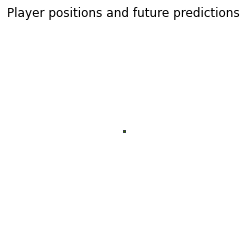

In [145]:
# Make a prediction with each model and compare it to the actual values

conn = sqlite3.connect(database_file)
cursor = conn.cursor()

data = fetch_data_batches(cursor, table_name, "1=1", 0, 1, data_features)

max_H = max(H_values)
max_T = max(T_values)

for (H, T, model_name), model in trained_models.items():
    input_shape = model_getters[model_name](H, T)[2]
    features = model_getters[model_name](H, T)[1]
    print(f"Predicting with model {model_name}")
    sequences = create_sequences_from_database_rows(data, H, T, max_H, max_T)
    X, y = sequences
    print(X.shape, y.shape)
    X_test_features = X[:, :, [
        data_features.index(feature) for feature in features]]
    for i in range(1):
        X_test = X_test_features[i]
        X_test_reshaped = X_test.reshape(input_shape)
        y_test = y[i]
        y_pred = model.predict(X_test_reshaped)[0]
        print(f"Model {model_name} - Sequence {i}")
        print(f"Predicted: {y_pred}")
        print(f"Actual: {y_test}")
        # Plot the predicted and actual values
        plot_prediction_on_plot(plt, X_test, [y_test[:2]], [
                                y_pred[:2]], "assets/2x_2dlevelminimap.png", normalized_zoom_range)